# **라이브러리 불러오기**

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tensorflow.keras.utils import to_categorical

In [3]:
train=pd.read_csv('../Data/train.csv')
test=pd.read_csv('../Data/test.csv')
submission=pd.read_csv('../Data/sample_submission.csv')

# **[데이터 살펴보기]**

In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [5]:
#null값 확인
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [14]:
# income_total과 DAYS_BIRTH 상관관계 높음 확인
# income_total과 begin_month, DAYS_EMPLOYED 간 역의 상관관계 확인
## income_total 과 DAYS_EMPLOYED는 DAYS_EMPLOYED 가 음수값을 갖기 때문에 역의 상관관계를 보임
train.corr()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
index,1.000000,0.001012,0.009848,-0.008901,0.004259,NaN,-0.005575,-0.001790,0.005332,-0.002867,0.002181,-0.007841
child_num,0.001012,1.000000,0.032186,0.332816,-0.228159,NaN,0.051521,-0.010555,0.016120,0.890530,-0.007229,0.004081
income_total,0.009848,0.032186,1.000000,0.064155,-0.166478,NaN,-0.034207,0.019013,0.089882,0.023839,-0.018047,0.008555
DAYS_BIRTH,-0.008901,0.332816,0.064155,1.000000,-0.616776,NaN,0.178752,-0.029247,0.111238,0.298108,0.057306,-0.025187
DAYS_EMPLOYED,0.004259,-0.228159,-0.166478,-0.616776,1.000000,NaN,-0.241827,-0.007749,-0.091090,-0.223077,0.007964,-0.003798
FLAG_MOBIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_phone,-0.005575,0.051521,-0.034207,0.178752,-0.241827,NaN,1.000000,0.310256,-0.031048,0.068705,-0.008563,-0.003134
phone,-0.001790,-0.010555,0.019013,-0.029247,-0.007749,NaN,0.310256,1.000000,0.012494,-0.000132,-0.014286,0.003452
email,0.005332,0.016120,0.089882,0.111238,-0.091090,NaN,-0.031048,0.012494,1.000000,0.016122,0.002320,0.014812
family_size,-0.002867,0.890530,0.023839,0.298108,-0.223077,NaN,0.068705,-0.000132,0.016122,1.000000,-0.023032,0.008227


<AxesSubplot:title={'center':'Correlation of Features'}>

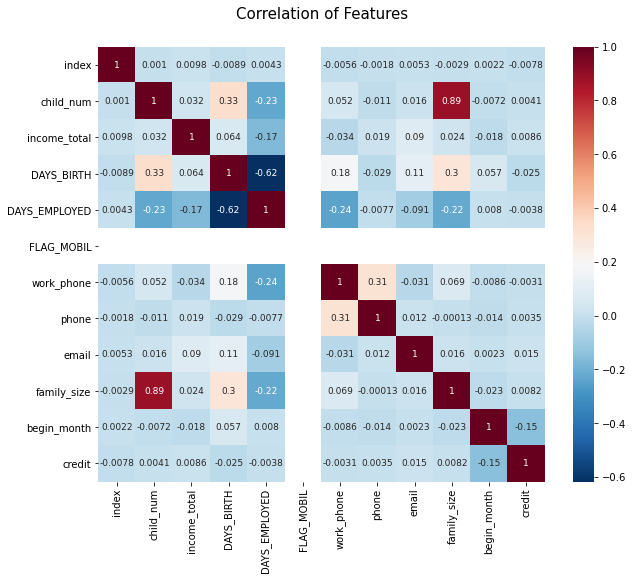

In [11]:
# 변수간 상관관계 분석(주의 : A와 B의 상관관계가 높다는 이야기는 함께 움직이는 경향이 있다는 것이지, "A를 증가하게 만들면 B가 증가할 것이다." 라는 말은 맞지 않음)
# 1에 가까울 수록 두개가 정비례 경향
# -1에 가까울 수록 반비례 경향
# 0에 가까울수록 두개간 관계가 없다
plt.figure(figsize=(10, 8))
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train.corr(), cmap = 'RdBu_r', linecolor = "white", annot = True, annot_kws = {"size" : 9})

In [6]:
# 재산과 신용도의 상관관계 분석 
property = (train['car'] == 'Y' )|(train['reality'] == 'Y')
data1 = train.loc[property, ['car','reality','credit']]
data1.value_counts()

car  reality  credit
N    Y        2.0       7019
Y    Y        2.0       4321
N    Y        1.0       2771
Y    N        2.0       2209
     Y        1.0       1561
N    Y        0.0       1369
Y    Y        0.0        789
     N        1.0        716
              0.0        451
dtype: int64

In [19]:
data1.shape

(21206, 3)

# **[데이터 전처리]**

## Feature 설명

- gender : 성별  (0)
- car : 차량 소유 여부  (0)
- reality : 부동산 소유 여부  (0)
- child_num : 자녀 수   (0)
- income_total : 연간 소득  (o)
- income_type : 소득 분류   
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   (0)
- edu_type : 교육 수준   
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']    (0)
- family_type : 결혼 여부   
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']    (0)
- house_type : 생활 방식   
    ['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']    (0)
- DAYS_BIRTH : 출생일   (0)
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
- DAYS_EMPLOYED : 업무 시작일   (0)   
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
- FLAG_MOBIL : 핸드폰 소유 여부  (0) -> drop 
- work_phone : 업무용 전화 소유 여부   (0)
- phone : 전화 소유 여부  (0) 
- email : 이메일 소유 여부   (0)
- occyp_type : 직업 유형	  (0) -> drop 											
- family_size : 가족 규모  (0) 
- begin_month : 신용카드 발급 월 
    => 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
- credit : 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함   

## **1. occyp_type, index, FLAG_MOBILE drop**
- FLAG_MOBILE : 모두 1값을 갖기때문에 의미 없음
- occyp_type : null 값

In [185]:
train.drop('occyp_type', axis=1, inplace=True)
test.drop('occyp_type', axis=1, inplace=True)

In [186]:
train.drop('FLAG_MOBIL', axis=1, inplace=True)
test.drop('FLAG_MOBIL', axis=1, inplace=True)

In [187]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

## **2. numeric -> categorical 변환**
- catboost를 돌리기 위한 categorical한 변수생성
    - child_num, family_size 
    - begin_month, DAYS_EMOPYED, DAYS_BIRTH, income_total : 이상치제거
    - work_phone, phone, email

### child_num

In [188]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [189]:
train.loc[train['child_num']>=3,'child_num'] = 3
test.loc[test['child_num']>=3, 'child_num'] = 3

In [190]:
train['child_num'].value_counts()

0    18340
1     5386
2     2362
3      369
Name: child_num, dtype: int64

In [191]:
test['child_num'] = test['child_num'].astype('object')
train['child_num'] = train['child_num'].astype('object')

In [192]:
train['child_num'].value_counts()

0    18340
1     5386
2     2362
3      369
Name: child_num, dtype: int64

In [193]:
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     139
Name: child_num, dtype: int64

### family_size

In [194]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [195]:
train.loc[train['family_size']>=5, 'family_size'] = 5
test.loc[test['family_size']>=5, 'family_size'] = 5

In [196]:
train['family_size'].value_counts()
#test['family_size'].value_counts()

2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      350
Name: family_size, dtype: int64

In [197]:
test['family_size'] = test['family_size'].astype('object')
train['family_size'] = train['family_size'].astype('object')

In [198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  object 
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  family_size    26457 non-null  object 
 15  begin_month    26457 non-null  float64
 16  credit         26457 non-null  float64
dtypes: float64(3), int64(5), object(9)
memory usage: 3

### begin_month

<AxesSubplot:ylabel='Frequency'>

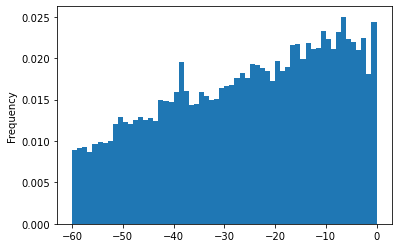

In [199]:
train['begin_month'].value_counts()
train['begin_month'].plot(kind='hist',bins=60,density=True)

<AxesSubplot:ylabel='Frequency'>

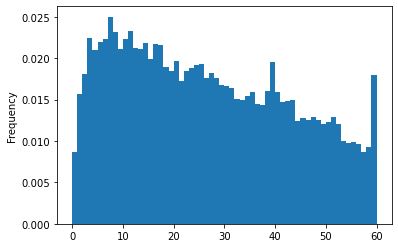

In [200]:
train['begin_month'] = abs(train['begin_month'])
test['begin_month'] = abs(test['begin_month'])

train['begin_month'].plot(kind='hist',bins=60,density=True)

#### standardscaler

In [145]:
# df_train = train['begin_month']
# df_test = test['begin_month']

# df_train = pd.DataFrame(df_train)
# df_test = pd.DataFrame(df_test)

# standard_scaler = StandardScaler()

# df_train = standard_scaler.fit_transform(df_train)
# df_test = standard_scaler.transform(df_test)

# train['begin_month'] = df_train
# test['begin_month'] = df_test

#### minmaxscaler

In [66]:
# df_train = train['begin_month']
# df_test = test['begin_month']

# df_train = pd.DataFrame(df_train)
# df_test = pd.DataFrame(df_test)

# minmax_scaler = MinMaxScaler()

# df_train = minmax_scaler.fit_transform(df_train)
# df_test = minmax_scaler.transform(df_test)

# train['begin_month'] = df_train
# test['begin_month'] = df_test

#### original

In [59]:
# plt.boxplot(train['begin_month'])

In [60]:
# # 년단위로 범주화 
# train_and_test = [train, test]
# for dataset in train_and_test :
#     Q1 = dataset['begin_month'].quantile(.25)
#     Q3 = dataset['begin_month'].quantile(.75)
#     IQR = Q3 - Q1
#     Q2 = dataset['begin_month'].quantile(.5)
#     Q4 = dataset['begin_month'].quantile(1)

# train.loc[train['begin_month'] <= Q1,'begin_month'] = 1
# train.loc[(train['begin_month'] > Q1) & (train['begin_month'] <= Q2),'begin_month'] = 2
# train.loc[(train['begin_month'] > Q2) & (train['begin_month'] <= Q3),'begin_month'] = 3
# train.loc[(train['begin_month'] > Q3) & (train['begin_month'] <= Q4),'begin_month'] = 4

# test.loc[test['begin_month'] <= Q1,'begin_month'] = 1
# test.loc[(test['begin_month'] > Q1) & (test['begin_month'] <= Q2),'begin_month'] = 2
# test.loc[(test['begin_month'] > Q2) & (test['begin_month'] <= Q3),'begin_month'] = 3
# test.loc[(test['begin_month'] > Q3) & (test['begin_month'] <= Q4),'begin_month'] = 4

# train['begin_month'] = train['begin_month'].replace([1,2,3,4],['A','B','C','D'])
# test['begin_month'] = test['begin_month'].replace([1,2,3,4],['A','B','C','D'])

In [61]:
# train['begin_month'].value_counts()

In [62]:
# test['begin_month'].value_counts()

### DAYS_EMPLOYED

#### minmaxscaler

In [115]:
# df_train = train['DAYS_EMPLOYED']
# df_test = test['DAYS_EMPLOYED']

# df_train = pd.DataFrame(df_train)
# df_test = pd.DataFrame(df_test)

# minmax_scaler = MinMaxScaler()

# df_train = minmax_scaler.fit_transform(df_train)
# df_test = minmax_scaler.transform(df_test)

# train['DAYS_EMPLOYED'] = df_train
# test['DAYS_EMPLOYED'] = df_test

#### original

In [201]:
train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

In [21]:
# train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
# test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])

In [22]:
# train['DAYS_EMPLOYED'].value_counts()

0       4438
401       57
1539      47
200       45
2087      44
        ... 
7864       1
1723       1
1755       1
5865       1
4305       1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

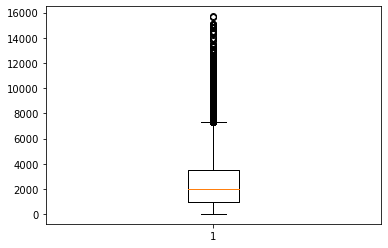

In [23]:
# plt.boxplot(train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'])
# plt.show()

In [24]:
# train_and_test = [train, test]
# for dataset in train_and_test :
#     Q1 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.25)
#     Q2 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.5)
#     Q3 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(0.75)
#     Q4 = train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'].quantile(1.0)
#     IQR = Q3 - Q1
    
# train.loc[train['DAYS_EMPLOYED'] == 0 ,'DAYS_EMPLOYED'] = 0
# train.loc[(train['DAYS_EMPLOYED'] != 0) & (train['DAYS_EMPLOYED'] <= Q1),'DAYS_EMPLOYED'] = 1
# train.loc[(train['DAYS_EMPLOYED'] > Q1) & (train['DAYS_EMPLOYED'] <= Q2),'DAYS_EMPLOYED'] = 2
# train.loc[(train['DAYS_EMPLOYED'] > Q2) & (train['DAYS_EMPLOYED'] <= Q3),'DAYS_EMPLOYED'] = 3
# train.loc[(train['DAYS_EMPLOYED'] > Q3) & (train['DAYS_EMPLOYED'] <= Q4),'DAYS_EMPLOYED'] = 4

# test.loc[test['DAYS_EMPLOYED'] == 0 ,'DAYS_EMPLOYED'] = 0
# test.loc[(test['DAYS_EMPLOYED'] != 0) & (test['DAYS_EMPLOYED'] <= Q1),'DAYS_EMPLOYED'] = 1
# test.loc[(test['DAYS_EMPLOYED'] > Q1) & (test['DAYS_EMPLOYED'] <= Q2),'DAYS_EMPLOYED'] = 2
# test.loc[(test['DAYS_EMPLOYED'] > Q2) & (test['DAYS_EMPLOYED'] <= Q3),'DAYS_EMPLOYED'] = 3
# test.loc[(test['DAYS_EMPLOYED'] > Q3) & (test['DAYS_EMPLOYED'] <= Q4),'DAYS_EMPLOYED'] = 4

# train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace([0,1,2,3,4],['A','B','C','D','E'])
# test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace([0,1,2,3,4],['A','B','C','D','E'])


In [25]:
# train['DAYS_EMPLOYED'].value_counts()

D    5511
C    5506
B    5505
E    5497
A    4438
Name: DAYS_EMPLOYED, dtype: int64

In [26]:
# test['DAYS_EMPLOYED'].value_counts()

D    2160
E    2060
C    2054
B    2029
A    1697
Name: DAYS_EMPLOYED, dtype: int64

### DAYS_BIRTH

#### minmaxscaler

In [116]:
# df_train = train['DAYS_BIRTH']
# df_test = test['DAYS_BIRTH']

# df_train = pd.DataFrame(df_train)
# df_test = pd.DataFrame(df_test)

# minmax_scaler = MinMaxScaler()

# df_train = minmax_scaler.fit_transform(df_train)
# df_test = minmax_scaler.transform(df_test)

# train['DAYS_BIRTH'] = df_train
# test['DAYS_BIRTH'] = df_test

#### original

<AxesSubplot:ylabel='Frequency'>

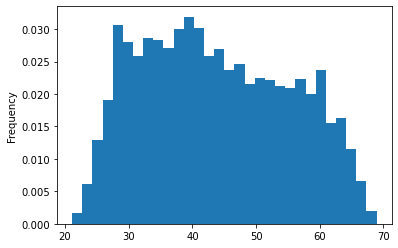

In [27]:
# train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH']/365)
# test['DAYS_BIRTH'] = abs(test['DAYS_BIRTH']/365)

# train['DAYS_BIRTH'].plot(kind='hist',bins=30,density=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x2026e3f4100>,
 'caps': [<matplotlib.lines.Line2D at 0x2026e3f47c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2026e3e5d60>],
 'medians': [<matplotlib.lines.Line2D at 0x2026e3f4e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2026e3fe220>],
 'means': []}

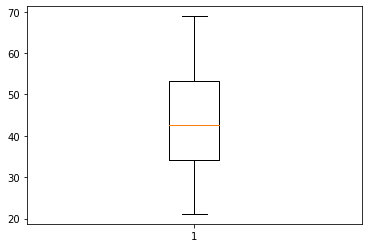

In [28]:
# plt.boxplot(train['DAYS_BIRTH'])

In [29]:
# train_and_test = [train, test]
# for dataset in train_and_test :
#     Q1 = train['DAYS_BIRTH'].quantile(.25)
#     Q3 = train['DAYS_BIRTH'].quantile(.75)
#     IQR = Q3 - Q1
#     Q2 = train['DAYS_BIRTH'].quantile(.5)
#     Q4 = train['DAYS_BIRTH'].quantile(1)


# train.loc[train['DAYS_BIRTH'] <= Q1,'DAYS_BIRTH'] = 1
# train.loc[(train['DAYS_BIRTH'] > Q1) & (train['DAYS_BIRTH'] <= Q2),'DAYS_BIRTH'] = 2
# train.loc[(train['DAYS_BIRTH'] > Q2) & (train['DAYS_BIRTH'] <= Q3),'DAYS_BIRTH'] = 3
# train.loc[(train['DAYS_BIRTH'] > Q3) & (train['DAYS_BIRTH'] <= Q4),'DAYS_BIRTH'] = 4

# test.loc[test['DAYS_BIRTH'] <= Q1,'DAYS_BIRTH'] = 1
# test.loc[(test['DAYS_BIRTH'] > Q1) & (test['DAYS_BIRTH'] <= Q2),'DAYS_BIRTH'] = 2
# test.loc[(test['DAYS_BIRTH'] > Q2) & (test['DAYS_BIRTH'] <= Q3),'DAYS_BIRTH'] = 3
# test.loc[(test['DAYS_BIRTH'] > Q3) & (test['DAYS_BIRTH'] <= Q4),'DAYS_BIRTH'] = 4

# test['DAYS_BIRTH'] = test['DAYS_BIRTH'].replace([1,2,3,4],['A','B','C','D'])
# train['DAYS_BIRTH'] = train['DAYS_BIRTH'].replace([1,2,3,4],['A','B','C','D'])

In [74]:
# train['DAYS_BIRTH'].value_counts()

In [75]:
# test['DAYS_BIRTH'].value_counts()

### income_total

#### log scale

In [202]:
for df in [train,test]:
    df['income_total'] = np.log(df['income_total'])

#### MinMax Scaler

In [117]:
# df_train = train['income_total']
# df_test = test['income_total']

In [118]:
# df_train = pd.DataFrame(df_train)
# df_test = pd.DataFrame(df_test)


In [119]:
# minmax_scaler = MinMaxScaler()

# df_train = minmax_scaler.fit_transform(df_train)
# df_test = minmax_scaler.transform(df_test)

In [120]:
# df_train

array([[0.11337209],
       [0.14244186],
       [0.27325581],
       ...,
       [0.17151163],
       [0.09302326],
       [0.03488372]])

In [121]:
# train['income_total'] = df_train
# test['income_total'] = df_test

In [122]:
# train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,0.113372,Commercial associate,Higher education,Married,Municipal apartment,0.644982,0.028885,0,0,0,2.0,0.100000,1.0
1,F,N,Y,1,0.142442,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.789362,0.037204,0,0,1,3.0,0.083333,1.0
2,M,Y,Y,0,0.273256,Working,Higher education,Married,House / apartment,0.347624,0.029607,0,1,0,2.0,0.366667,2.0
3,F,N,Y,0,0.113372,Commercial associate,Secondary / secondary special,Married,House / apartment,0.576833,0.035755,0,1,0,2.0,0.616667,0.0
4,F,Y,Y,0,0.084302,State servant,Higher education,Married,House / apartment,0.579756,0.035721,0,0,0,2.0,0.433333,2.0


#### original

In [217]:
# train['income_total'].value_counts()

135000.0    3164
157500.0    2233
180000.0    2225
112500.0    2178
225000.0    2170
            ... 
227250.0       1
91530.0        1
39600.0        1
432000.0       1
215100.0       1
Name: income_total, Length: 249, dtype: int64

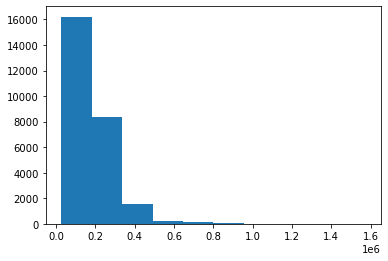

In [31]:
# plt.hist(train['income_total'])
# plt.show()

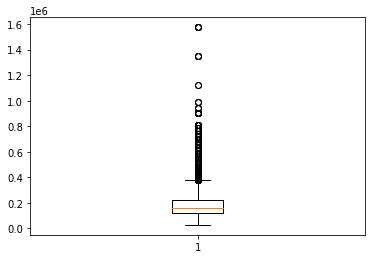

In [32]:
# plt.boxplot(train['income_total'])

# plt.show()

In [33]:
# train_and_test = [train, test]
# for dataset in train_and_test :
#     Q1 = train['income_total'].quantile(.25)
#     Q3 = train['income_total'].quantile(.75)
#     IQR = Q3 - Q1
#     Q2 = train['income_total'].quantile(.5)
#     Q4 = train['income_total'].quantile(1)


# train.loc[train['income_total'] <= Q1,'income_total'] = 1
# train.loc[(train['income_total'] > Q1) & (train['income_total'] <= Q2),'income_total'] = 2
# train.loc[(train['income_total'] > Q2) & (train['income_total'] <= Q3),'income_total'] = 3
# train.loc[(train['income_total'] > Q3) & (train['income_total'] <= Q4),'income_total'] = 4

# test.loc[test['income_total'] <= Q1,'income_total'] = 1
# test.loc[(test['income_total'] > Q1) & (test['income_total'] <= Q2),'income_total'] = 2
# test.loc[(test['income_total'] > Q2) & (test['income_total'] <= Q3),'income_total'] = 3
# test.loc[(test['income_total'] > Q3) & (test['income_total'] <= Q4),'income_total'] = 4


# test['income_total'] = test['income_total'].replace([1,2,3,4],['A','B','C','D'])
# train['income_total'] = train['income_total'].replace([1,2,3,4],['A','B','C','D'])

In [34]:
# train['income_total'].value_counts()

C    7334
A    6751
B    6685
D    5687
Name: income_total, dtype: int64

In [35]:
# test['income_total'].value_counts()

C    2791
A    2642
B    2485
D    2082
Name: income_total, dtype: int64

### work_phone, phone

In [203]:
train['work_phone'].value_counts()
test['work_phone'].value_counts()

0    7724
1    2276
Name: work_phone, dtype: int64

In [204]:
train['work_phone'] = train['work_phone'].replace([0,1],['Y','N'])
test['work_phone'] = test['work_phone'].replace([0,1],['Y','N'])

In [205]:
train['phone'].value_counts()
test['phone'].value_counts()

0    7037
1    2963
Name: phone, dtype: int64

In [206]:
train['phone'] = train['phone'].replace([0,1],['Y','N'])
test['phone'] = test['phone'].replace([0,1],['Y','N'])

### email 

In [207]:
train['email'].value_counts()

0    24042
1     2415
Name: email, dtype: int64

In [208]:
train['email'] = train['email'].replace([0,1],['Y','N'])
test['email'] = test['email'].replace([0,1],['Y','N'])

## **3. 중복컬럼**

In [133]:
# # 성별, 연간 소득, 소득 분류, 출생일, 업무 시작일의 변수를 하나로 만들어 줌 (추후 동일 인물 파악에 사용)

# train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]
# test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'])]

# print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
# print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
# print('-'*60)
# print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
# print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 3209명
test set 중복데이터가 아닌 사람의 수 : 3103명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 5518명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 2468명


## **4. scaling**
- categorical 변수들 standard scaling

In [209]:
# numerical 변수 확인
numerical_feats = train.dtypes[train.dtypes != 'object'].index.tolist() #인덱스를 리스트로 생성
numerical_feats.remove('credit')
print("Numerical features : ", numerical_feats)

# categorical 변수 확인
categorical_feats = train.dtypes[train.dtypes == 'object'].index.tolist()
print("Categorical features : ", categorical_feats)

Numerical features :  ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
Categorical features :  ['gender', 'car', 'reality', 'child_num', 'income_type', 'edu_type', 'family_type', 'house_type', 'work_phone', 'phone', 'email', 'family_size']


In [210]:
# logscale 한 income_total 제외하고 categorical 변수 standard scaling
numerical_feats.remove('income_total')
standard_scaler = StandardScaler()

train[numerical_feats] = standard_scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = standard_scaler.transform(test[numerical_feats])

## **5. Kmeans Clustering**

In [ ]:
# from sklearn.cluster import KMeans

# kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=20).fit(kmeans_train)

# train['cluster'] = kmeans.predict(kmeans_train)
# test['cluster'] = kmeans.predict(test)

## 확인

In [50]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,0,C,Commercial associate,Higher education,Married,Municipal apartment,B,E,Y,Y,Y,2.0,A,1.0
1,F,N,Y,1,D,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,A,C,Y,Y,N,3.0,A,1.0
2,M,Y,Y,0,D,Working,Higher education,Married,House / apartment,C,E,Y,N,Y,2.0,B,2.0
3,F,N,Y,0,C,Commercial associate,Secondary / secondary special,Married,House / apartment,B,D,Y,N,Y,2.0,C,0.0
4,F,Y,Y,0,B,State servant,Higher education,Married,House / apartment,B,D,Y,Y,Y,2.0,C,2.0


In [51]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,M,Y,N,0,A,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,D,A,Y,N,Y,2.0,D
1,F,N,Y,0,B,State servant,Higher education,Married,House / apartment,C,E,Y,N,Y,2.0,C
2,F,N,Y,0,A,Working,Secondary / secondary special,Married,House / apartment,C,B,N,N,Y,2.0,D
3,M,Y,N,0,A,Commercial associate,Secondary / secondary special,Married,House / apartment,C,D,N,Y,Y,2.0,D
4,F,Y,Y,0,C,State servant,Higher education,Married,House / apartment,C,E,N,Y,Y,2.0,A


In [52]:
train.shape

(26457, 17)

In [53]:
test.shape

(10000, 16)

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  object 
 4   income_total   26457 non-null  object 
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  object 
 10  DAYS_EMPLOYED  26457 non-null  object 
 11  work_phone     26457 non-null  object 
 12  phone          26457 non-null  object 
 13  email          26457 non-null  object 
 14  family_size    26457 non-null  object 
 15  begin_month    26457 non-null  object 
 16  credit         26457 non-null  float64
dtypes: float64(1), object(16)
memory usage: 3.4+ MB


# **[데이터 모델링]**

In [211]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [212]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 16) (26457, 1) (10000, 16)


### 0. Stacking

In [214]:
# one-hot encoding
train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)

In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=21)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=21))),
    ('cat', CatBoostClassifier(random_state=21)),
    ('xgb', XGBClassifier(random_state=21)),
    ('lgb', LGBMClassifier(random_state=21))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 21)
clf.fit(X_train, y_train).score(X_val, y_val)

Learning rate set to 0.092151
0:	learn: 1.0467250	total: 6.63ms	remaining: 6.62s
1:	learn: 1.0060501	total: 12.3ms	remaining: 6.12s
2:	learn: 0.9732027	total: 18.6ms	remaining: 6.18s
3:	learn: 0.9465356	total: 21.6ms	remaining: 5.37s
4:	learn: 0.9242936	total: 27.1ms	remaining: 5.4s
5:	learn: 0.9058781	total: 32.9ms	remaining: 5.44s
6:	learn: 0.8905143	total: 39ms	remaining: 5.54s
7:	learn: 0.8777876	total: 44.6ms	remaining: 5.53s
8:	learn: 0.8675351	total: 49.8ms	remaining: 5.48s
9:	learn: 0.8585139	total: 55.2ms	remaining: 5.46s
10:	learn: 0.8505723	total: 59.8ms	remaining: 5.37s
11:	learn: 0.8436981	total: 65.3ms	remaining: 5.37s
12:	learn: 0.8377225	total: 70.9ms	remaining: 5.38s
13:	learn: 0.8328524	total: 76.1ms	remaining: 5.36s
14:	learn: 0.8291529	total: 80.9ms	remaining: 5.31s
15:	learn: 0.8252315	total: 86.5ms	remaining: 5.32s
16:	learn: 0.8223455	total: 91.5ms	remaining: 5.29s
17:	learn: 0.8200645	total: 96.5ms	remaining: 5.27s
18:	learn: 0.8179292	total: 103ms	remaining: 5.

0.7118669690098262

In [217]:
y_pred = clf.predict_proba(test_x)
y_pred.shape

(10000, 3)

In [219]:
y_val_pred = clf.predict_proba(X_val)

In [221]:
y_val_pred

array([[0.17001838, 0.15981435, 0.67016727],
       [0.44016462, 0.13480984, 0.42502554],
       [0.16279577, 0.76946044, 0.06774379],
       ...,
       [0.05701418, 0.10045968, 0.84252615],
       [0.06168293, 0.1919266 , 0.74639046],
       [0.06430919, 0.12268244, 0.81300836]])

In [222]:
print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_val_pred)}")

log_loss: 0.7300628719998362


In [223]:
submission.loc[:,1:]=y_pred

In [224]:
submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_stacking1.csv', index=False)

### 1. Random Forest

In [52]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
clf=RandomForestClassifier(n_estimators = 400, max_depth = 10, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.662
테스트 세트 정확도: 0.642
log_loss: 0.848991218301675


In [57]:
print("특성 중요도:\n{}".format(clf.feature_importances_))

특성 중요도:
[0.20641654 0.03045403 0.0326307  0.02908583 0.02735945 0.03515414
 0.04334575 0.04458918 0.050692   0.04602408 0.09457275 0.01158531
 0.         0.02788728 0.03052253 0.02190098 0.04722298 0.22055646]


<AxesSubplot:>

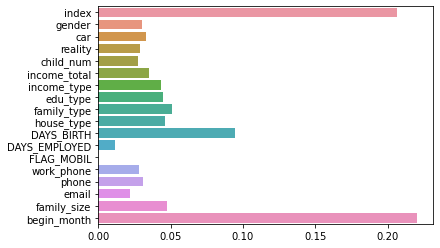

In [75]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(clf.feature_importances_, y=feature_names)

In [30]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.8508510800735897
FOLD 1 : logloss:0.8488090912324694
FOLD 2 : logloss:0.8497394818279445
FOLD 3 : logloss:0.8475365305229623
FOLD 4 : logloss:0.8457256151627915
Mean:0.8485323597639514


In [392]:
my_submission

(26457, 3)

In [32]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [33]:
submission.loc[:,1:]=my_submission

In [34]:
submission

,index,0,1,2
0,26457,0.118916,0.219820,0.661264
1,26458,0.109289,0.220176,0.670535
2,26459,0.102643,0.249998,0.647359
3,26460,0.131527,0.204577,0.663896
4,26461,0.143888,0.323971,0.532140
...,...,...,...,...
9995,36452,0.110772,0.267286,0.621942
9996,36453,0.094696,0.327186,0.578118
9997,36454,0.108017,0.196897,0.695085
9998,36455,0.120710,0.247378,0.631912


In [36]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_rf.csv', index=False)

### 2. AdaBoost

In [76]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
ada_clf= AdaBoostClassifier(random_state = 10, n_estimators = 10) 
ada_clf.fit(X_train, y_train)
y_pred=ada_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(ada_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ada_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.641
테스트 세트 정확도: 0.641
log_loss: 1.0523664981586929


<AxesSubplot:>

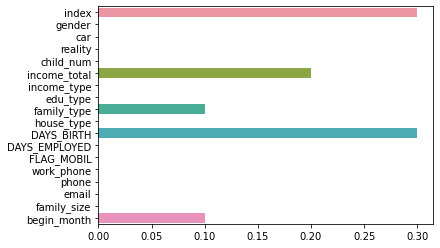

In [77]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(ada_clf.feature_importances_, y=feature_names)

In [78]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(ada_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        ada_clf.fit(X_train, y_train)
        
        predictions=ada_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=ada_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(ada_clf)

FOLD 0 : logloss:1.0525183950848656
FOLD 1 : logloss:1.0521019669592764
FOLD 2 : logloss:1.052028698077584
FOLD 3 : logloss:1.05471162757762
FOLD 4 : logloss:1.0522401565514188
Mean:1.052720168850153


In [79]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_ada.csv', index=False)

### 3. GBM

In [80]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
gb_clf=GradientBoostingClassifier(max_depth = 6, n_estimators = 700 ,learning_rate = 0.01)
gb_clf.fit(X_train, y_train)
y_pred=gb_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(gb_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gb_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.676
테스트 세트 정확도: 0.640
log_loss: 0.8594515834778458


<AxesSubplot:>

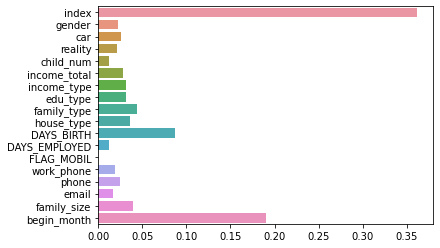

In [81]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(gb_clf.feature_importances_, y=feature_names)

In [82]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(gb_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        gb_clf.fit(X_train, y_train)
        
        predictions=gb_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=gb_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(gb_clf)

FOLD 0 : logloss:0.8591750366251788
FOLD 1 : logloss:0.8597680603979402
FOLD 2 : logloss:0.8581145215201603
FOLD 3 : logloss:0.8610761353677229
FOLD 4 : logloss:0.8588016115777816
Mean:0.8593870730977567


In [83]:
submission.loc[:,1:]=my_submission

In [84]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_gb.csv', index=False)

### 4. XGBoost

In [86]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
xgb_clf=XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgb_clf.fit(X_train, y_train)
y_pred=xgb_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(xgb_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(xgb_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

[01:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 세트 정확도: 0.667
테스트 세트 정확도: 0.639
log_loss: 0.8599134544790557


<AxesSubplot:>

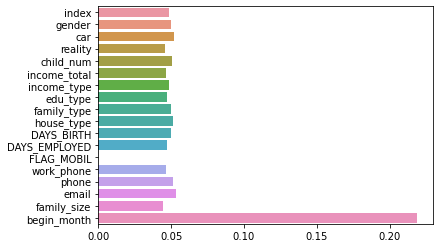

In [87]:
# 특성 중요도 시각화
import seaborn as sns
feature_names = list(train_x.columns)
sns.barplot(xgb_clf.feature_importances_, y=feature_names)

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(xgb_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        xgb_clf.fit(X_train, y_train)
        
        predictions=xgb_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=xgb_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(xgb_clf)

[01:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 0 : logloss:0.8577801340955816
[01:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
FOLD 1 : logloss:0.8574832625298543
[01:40:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behav

In [ ]:
submission.loc[:,1:]=my_submission

In [ ]:
submission.to_csv('D:/지연/credit_project/data/baseline_submission_xgb.csv', index=False)

### 5. CATboost

#### one-hot encoder : get_dummies

In [215]:
train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)

In [216]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0462056	total: 32.4ms	remaining: 32.4s
1:	learn: 1.0054589	total: 34.9ms	remaining: 17.4s
2:	learn: 0.9721226	total: 38.9ms	remaining: 12.9s
3:	learn: 0.9447802	total: 43.2ms	remaining: 10.8s
4:	learn: 0.9221243	total: 48ms	remaining: 9.55s
5:	learn: 0.9039763	total: 52ms	remaining: 8.62s
6:	learn: 0.8884555	total: 56.4ms	remaining: 7.99s
7:	learn: 0.8759171	total: 60.3ms	remaining: 7.48s
8:	learn: 0.8648295	total: 65ms	remaining: 7.16s
9:	learn: 0.8562941	total: 69.1ms	remaining: 6.84s
10:	learn: 0.8482740	total: 73.4ms	remaining: 6.6s
11:	learn: 0.8422311	total: 77.8ms	remaining: 6.41s
12:	learn: 0.8363418	total: 82.1ms	remaining: 6.23s
13:	learn: 0.8316857	total: 86.1ms	remaining: 6.06s
14:	learn: 0.8279303	total: 89.3ms	remaining: 5.87s
15:	learn: 0.8241148	total: 93.7ms	remaining: 5.76s
16:	learn: 0.8207413	total: 98.1ms	remaining: 5.67s
17:	learn: 0.8184447	total: 102ms	remaining: 5.57s
18:	learn: 0.8157938	total: 107ms	remaining: 5.54s
1

<AxesSubplot:>

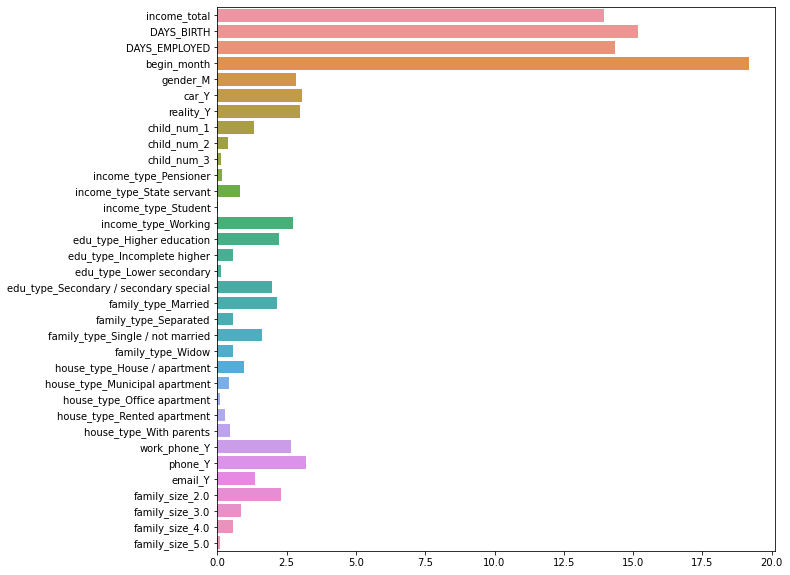

In [217]:
# 특성 중요도 시각화
import seaborn as sns
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(cat_clf.feature_importances_, y=feature_names)

In [218]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0458527	total: 4.65ms	remaining: 4.64s
1:	learn: 1.0051749	total: 7.39ms	remaining: 3.69s
2:	learn: 0.9719964	total: 12.5ms	remaining: 4.15s
3:	learn: 0.9446932	total: 17ms	remaining: 4.24s
4:	learn: 0.9228023	total: 21.1ms	remaining: 4.19s
5:	learn: 0.9046727	total: 25.3ms	remaining: 4.19s
6:	learn: 0.8890563	total: 30.6ms	remaining: 4.34s
7:	learn: 0.8765871	total: 35.2ms	remaining: 4.36s
8:	learn: 0.8654995	total: 39.6ms	remaining: 4.36s
9:	learn: 0.8570669	total: 44.3ms	remaining: 4.39s
10:	learn: 0.8490112	total: 49.6ms	remaining: 4.46s
11:	learn: 0.8429298	total: 54.5ms	remaining: 4.49s
12:	learn: 0.8370264	total: 59.2ms	remaining: 4.5s
13:	learn: 0.8325528	total: 62.7ms	remaining: 4.42s
14:	learn: 0.8285133	total: 67ms	remaining: 4.4s
15:	learn: 0.8246971	total: 71.4ms	remaining: 4.39s
16:	learn: 0.8214099	total: 76.1ms	remaining: 4.4s
17:	learn: 0.8190105	total: 80.4ms	remaining: 4.38s
18:	learn: 0.8164664	total: 84.3ms	remaining: 4.35s

In [79]:
submission.loc[:,1:]=my_submission

In [80]:
submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_cat_onehot4_beginmonth.csv', index=False)

#### ordinal

In [499]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

train_x = ordinal_encoder.fit_transform(train_x.values.tolist())
train_x.shape

test_x = ordinal_encoder.fit_transform(test_x.values.tolist())
test_x.shape


(10000, 16)

In [500]:
train_x = pd.DataFrame(train_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])
test_x = pd.DataFrame(test_x, columns=[['gender','car','reality','child_num','income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','phone','email','family_size','begin_month']])

In [501]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month
0,0.0,0.0,0.0,0.0,145.0,0.0,1.0,1.0,2.0,4236.0,863.0,1.0,1.0,1.0,1.0,6.0
1,0.0,0.0,1.0,1.0,165.0,0.0,4.0,0.0,1.0,5461.0,2421.0,1.0,1.0,0.0,2.0,5.0
2,1.0,1.0,1.0,0.0,214.0,4.0,1.0,1.0,1.0,1906.0,967.0,1.0,0.0,1.0,1.0,22.0
3,0.0,0.0,1.0,0.0,145.0,0.0,4.0,1.0,1.0,3662.0,2065.0,1.0,0.0,1.0,1.0,37.0
4,0.0,1.0,1.0,0.0,111.0,2.0,1.0,1.0,1.0,3685.0,2059.0,1.0,1.0,1.0,1.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.0,0.0,0.0,2.0,156.0,2.0,4.0,1.0,1.0,5127.0,2138.0,1.0,1.0,1.0,3.0,2.0
26453,0.0,0.0,1.0,1.0,133.0,4.0,1.0,2.0,1.0,3552.0,1836.0,1.0,1.0,1.0,1.0,47.0
26454,0.0,1.0,0.0,0.0,181.0,4.0,4.0,0.0,5.0,6083.0,2115.0,1.0,1.0,1.0,1.0,25.0
26455,1.0,0.0,1.0,0.0,121.0,4.0,2.0,3.0,1.0,6045.0,3444.0,1.0,1.0,1.0,0.0,59.0


#### clustring
- k-means의 무작위성 보완

In [531]:
# from sklearn.cluster import KMeans

# #kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=100, random_state=20).fit(train_x)

# train['cluster'] = kmeans.predict(train_x)
# test['cluster'] = kmeans.predict(test_x)

18    708
32    682
69    677
87    675
3     622
     ... 
72    128
74    126
30    109
91     72
27     52
Name: cluster, Length: 100, dtype: int64


<AxesSubplot:>

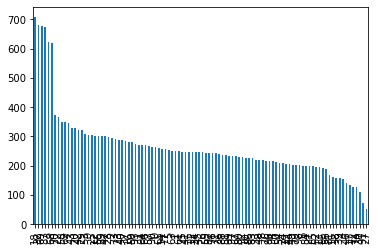

In [536]:
# cluster_size = train['cluster'].value_counts()

# print(cluster_size)
# cluster_size.plot(kind = 'bar')

In [532]:
# # 군집의 품질 평가
# print('왜곡 : %.2f' % kmeans.inertia_)

왜곡 : 752541372.09


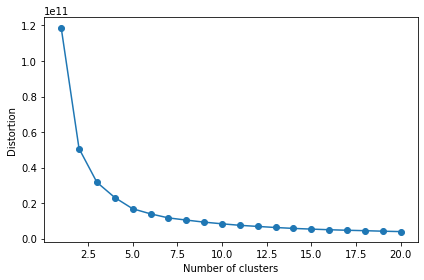

In [524]:
# # 엘보우 방법 : 왜곡 값이 적절한 값인지는 k를 다양한 값으로 할당한 후에 왜곡값을 비교(사람의 팔꿈치 형상)
# # 최적인 클러스터 개수 k를 추정
# # k값의 증가 → 센트로이드의 증가 →데이터들이 센트로이드에 더 가까워지는 것 → 왜곡값(SSE)의 감소

# distortions = [] 
# for i in range(1, 21) : 
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 0) 
#     kmeans.fit(train_x) 
#     distortions.append(kmeans.inertia_) 
    
# plt.plot(range(1,21), distortions, marker = 'o') 
# plt.xlabel('Number of clusters') 
# plt.ylabel('Distortion') 
# plt.tight_layout() 
# plt.show()


#### modeling

In [521]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0467842	total: 16.4ms	remaining: 16.4s
1:	learn: 1.0056910	total: 21.1ms	remaining: 10.5s
2:	learn: 0.9724270	total: 25ms	remaining: 8.29s
3:	learn: 0.9453467	total: 28.8ms	remaining: 7.16s
4:	learn: 0.9226650	total: 32.8ms	remaining: 6.53s
5:	learn: 0.9043543	total: 36.9ms	remaining: 6.11s
6:	learn: 0.8887139	total: 40.9ms	remaining: 5.8s
7:	learn: 0.8757342	total: 44.9ms	remaining: 5.56s
8:	learn: 0.8653137	total: 49.2ms	remaining: 5.41s
9:	learn: 0.8561508	total: 53.6ms	remaining: 5.3s
10:	learn: 0.8483931	total: 57.5ms	remaining: 5.17s
11:	learn: 0.8416612	total: 61.2ms	remaining: 5.04s
12:	learn: 0.8359927	total: 65.4ms	remaining: 4.97s
13:	learn: 0.8316536	total: 69.8ms	remaining: 4.92s
14:	learn: 0.8271949	total: 74.1ms	remaining: 4.86s
15:	learn: 0.8236350	total: 77.9ms	remaining: 4.79s
16:	learn: 0.8205936	total: 82.2ms	remaining: 4.75s
17:	learn: 0.8177525	total: 86.5ms	remaining: 4.72s
18:	learn: 0.8152333	total: 90.6ms	remaining: 4.

Text(0.5, 1.0, 'Confusion Matrix')

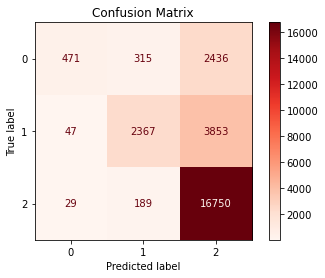

In [523]:
# confusion matrix

label=['0', '1', '2'] # 라벨 설정
plot = plot_confusion_matrix(cat_clf, # 분류 모델
                             train_x, train_y, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Reds, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

In [537]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0469632	total: 12.7ms	remaining: 12.7s
1:	learn: 1.0059258	total: 17.3ms	remaining: 8.65s
2:	learn: 0.9726558	total: 21.7ms	remaining: 7.21s
3:	learn: 0.9456674	total: 25.7ms	remaining: 6.41s
4:	learn: 0.9230539	total: 29.6ms	remaining: 5.89s
5:	learn: 0.9045683	total: 34.3ms	remaining: 5.68s
6:	learn: 0.8891462	total: 38.8ms	remaining: 5.51s
7:	learn: 0.8765945	total: 43.6ms	remaining: 5.41s
8:	learn: 0.8661562	total: 48.2ms	remaining: 5.31s
9:	learn: 0.8568858	total: 53.3ms	remaining: 5.28s
10:	learn: 0.8490402	total: 57.2ms	remaining: 5.14s
11:	learn: 0.8423703	total: 61.1ms	remaining: 5.03s
12:	learn: 0.8365245	total: 65.6ms	remaining: 4.98s
13:	learn: 0.8321286	total: 70.2ms	remaining: 4.94s
14:	learn: 0.8278309	total: 74.5ms	remaining: 4.89s
15:	learn: 0.8241916	total: 78.4ms	remaining: 4.82s
16:	learn: 0.8211812	total: 83.1ms	remaining: 4.81s
17:	learn: 0.8185680	total: 87.2ms	remaining: 4.76s
18:	learn: 0.8161504	total: 91.4ms	remaining

In [ ]:
# import graphviz
# cat_clf.plot_tree(tree_idx = 0)

In [183]:
my_submission.shape

(10000, 3)

In [538]:
submission.loc[:,1:]=my_submission

In [539]:
submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_cat_ord_logscale_standard_kmeans.csv', index=False)

### 6. LGBM

#### get_dummies

In [91]:
train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)

In [96]:
train_x.head()

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,begin_month,gender_M,car_Y,reality_Y,child_num_1,child_num_2,child_num_3,...,house_type_Office apartment,house_type_Rented apartment,house_type_With parents,work_phone_Y,phone_Y,email_Y,family_size_2.0,family_size_3.0,family_size_4.0,family_size_5.0
0,0.113372,-13899,-4709,-6.0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,0.142442,-11380,-1540,-5.0,0,0,1,1,0,0,...,0,0,0,1,1,0,0,1,0,0
2,0.273256,-19087,-4434,-22.0,1,1,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,0.113372,-15088,-2092,-37.0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,0.084302,-15037,-2105,-26.0,0,1,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0


In [92]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
lgbm_clf=LGBMClassifier(n_estimators = 100, learning_rate = 0.1)
lgbm_clf.fit(X_train, y_train)
y_pred=lgbm_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.724
테스트 세트 정확도: 0.698
log_loss: 0.7620329378257372


In [93]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(lgbm_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        lgbm_clf.fit(X_train, y_train)
        
        predictions=lgbm_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=lgbm_clf.predict_proba(test_x)
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(lgbm_clf)

FOLD 0 : logloss:0.7593946093819718
FOLD 1 : logloss:0.7547287904032101
FOLD 2 : logloss:0.7540199431577391
FOLD 3 : logloss:0.756778828714908
FOLD 4 : logloss:0.7543812867594757
Mean:0.7558606916834609


<AxesSubplot:>

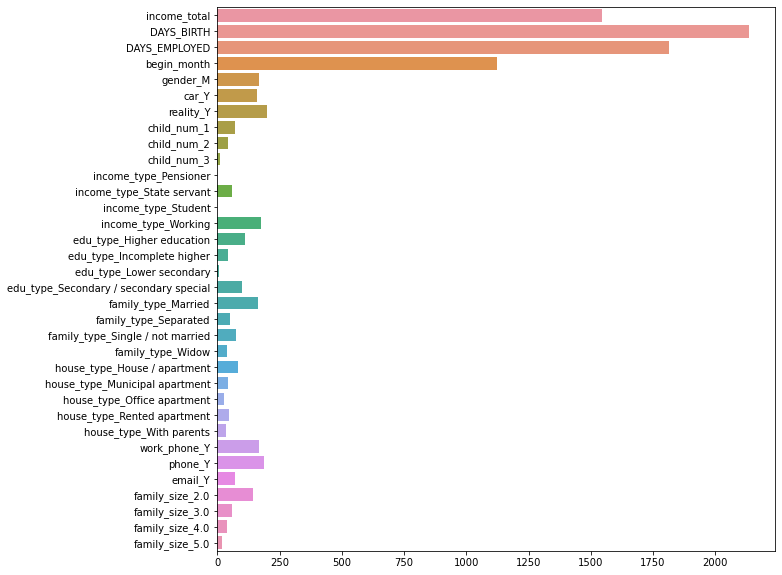

In [98]:
import seaborn as sns
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(lgbm_clf.feature_importances_, y=feature_names)

In [94]:
submission.loc[:,1:]=my_submission

In [95]:
submission.to_csv('C:/Users/qorwl/Documents/credit_project/data/baseline_submission_lgbm_onehot.csv', index=False)

#### ordinal 

In [232]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

train_x = ordinal_encoder.fit_transform(train_x.values.tolist())
train_x.shape

test_x = ordinal_encoder.fit_transform(test_x.values.tolist())
test_x.shape

(10000, 16)

In [233]:
train_x

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 2., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 3.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [234]:
type(y_train)

pandas.core.frame.DataFrame

In [235]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
lgbm_clf=LGBMClassifier(n_estimators = 100, learning_rate = 0.1)
lgbm_clf.fit(X_train, y_train)
y_pred=lgbm_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

훈련 세트 정확도: 0.679
테스트 세트 정확도: 0.654
log_loss: 0.8292286571587854
